In [1]:
!apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:

!unrar x data.rar unzipped_folder/


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/31da1b43-834a-4fb0-8347-e9f27f65fa1f___UF.GRC_BS_Lab Leaf 0836.JPG      46%  OK 
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/31ebf507-8a9d-42ac-89fa-54cbc98cc1d9___GCREC_Bact.Sp 6388.JPG      46%  OK 
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/32198276-01c5-4088-bb55-2ccae3c95c87___GCREC_Bact.Sp 3015.JPG      46%  OK 
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/32231fc1-ec78-45c6-9c7a-8412a7e38a25___GCREC_Bact.Sp 6143.JPG      46%  OK 
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/32600a73-f03e-448b-b0a2-dcf5e894eac7___GCREC_Bact.Sp 5587.JPG      46%  OK 
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/328b1cc5-6ac5-4689-9979-78bda50f5eec___GCREC_Bact.Sp 2949.JPG      47%  OK 
Extracting  unzipped_folder/data/Tomato___Bacterial_spot/32d7007e

# **Importation**

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras


# **Dataset**

In [4]:
#Constants
batch_size = 42
img_height = 200
img_width = 200 #the size of the input picture


In [5]:
data_train = "/content/unzipped_folder/data"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    validation_split=0.25,          # Reserve 25% of data for validation
    subset="training",             # Subset used for training
    seed=123,                      # Seed for randomization
    image_size=(img_height, img_width),  # Resize images to (200, 200)
    batch_size=batch_size          # Number of images to return in each batch
)

Found 9003 files belonging to 9 classes.
Using 6753 files for training.


In [6]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    validation_split=0.25,
    subset="validation",           # Subset used for validation
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 9003 files belonging to 9 classes.
Using 2250 files for validation.


In [7]:
#Class names from the dataset
class_names = train_dataset.class_names
print(class_names)

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']


# **Sample of our training pictures**

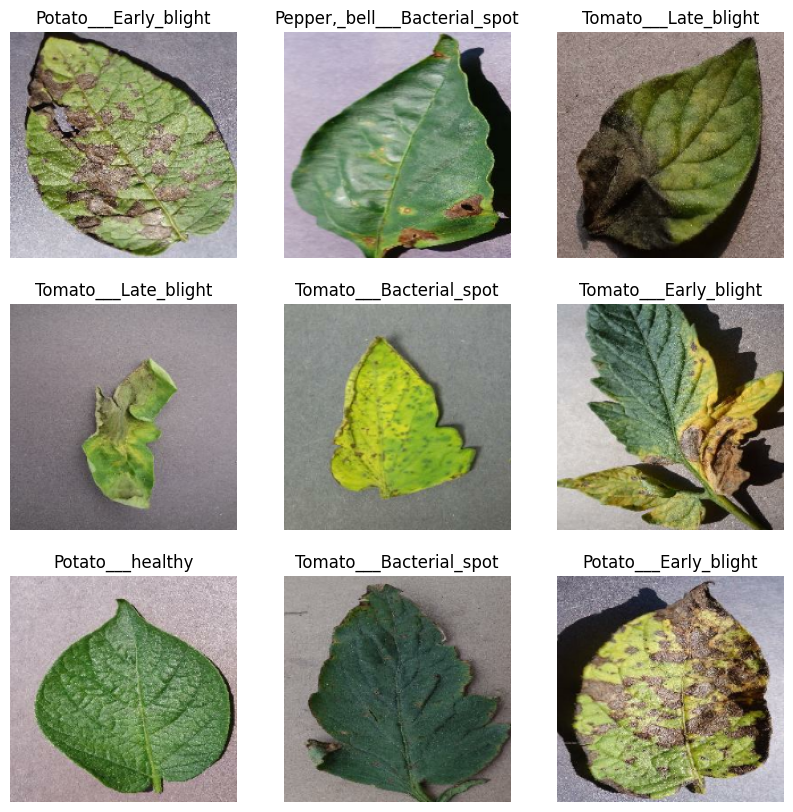

In [8]:
# sample picture for the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(2):  # Take two batches of images
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for display
        plt.title(class_names[labels[i]])  # Display the corresponding class name
        plt.axis("off")  # Turn off axis

# **Normalize our dataset**

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))


In [11]:
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
print("Minimum value:", np.min(first_image), "Maximum value:", np.max(first_image))

Minimum value: 0.0 Maximum value: 0.7016938


In [12]:
num_classes = len(class_names)


# **Build Model **

In [13]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Rescale input images
    layers.Conv2D(16, 3, padding='same', activation='relu'),          # 16 filters, 3x3 kernel
    layers.MaxPooling2D(),                                            # Downsample the input
    layers.Conv2D(32, 3, padding='same', activation='relu'),          # 32 filters, 3x3 kernel
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),          # 64 filters, 3x3 kernel
    layers.MaxPooling2D(),
    layers.Flatten(),                                                 # Flatten the input
    layers.Dense(128, activation='relu'),                             # Fully connected layer
    layers.Dense(num_classes)                                         # Output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Compile the model with Adam optimizer and Sparse Categorical Crossentropy loss
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

model.summary()  # Print the model architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,120,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,144,873 (19.63 MB)

 Trainable params: 5,144,873 (19.63 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [15]:
# Train the model for 15 epochs
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Extract and plot training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.4293 - loss: 1.6575 - val_accuracy: 0.8129 - val_loss: 0.5814
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8354 - loss: 0.4874 - val_accuracy: 0.8436 - val_loss: 0.4634
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9134 - loss: 0.2448 - val_accuracy: 0.8791 - val_loss: 0.3731
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9397 - loss: 0.1715 - val_accuracy: 0.8764 - val_loss: 0.3752
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9618 - loss: 0.1246 - val_accuracy: 0.8569 - val_loss: 0.4887
Epoch 6/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9694 - loss: 0.0890 - val_accuracy: 0.9031 - val_loss: 0.3390
Epoch 7/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9787 - loss: 0.0640 - val_accuracy: 0.8764 - val_loss: 0.4712
Epoch 8/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9889 - loss: 0.0368 - val_ac

**The training and Validation accuracy **

Text(0.5, 1.0, 'Training and Validation Accuracy')

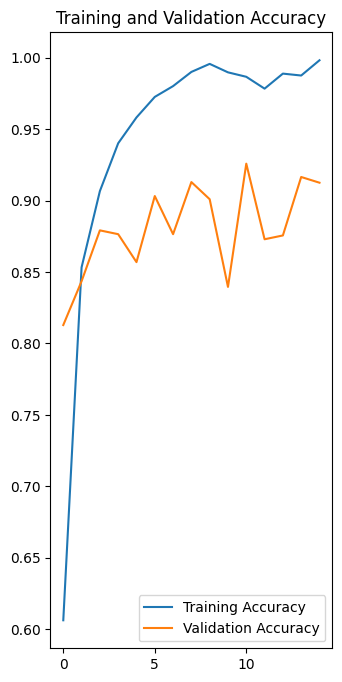

In [16]:
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# **The training and validation loss**

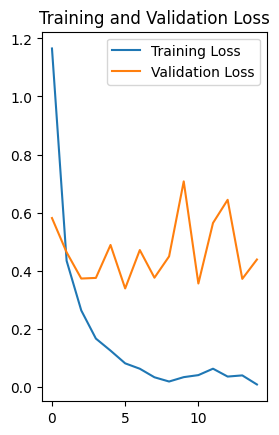

In [17]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Data Augmentation layers**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


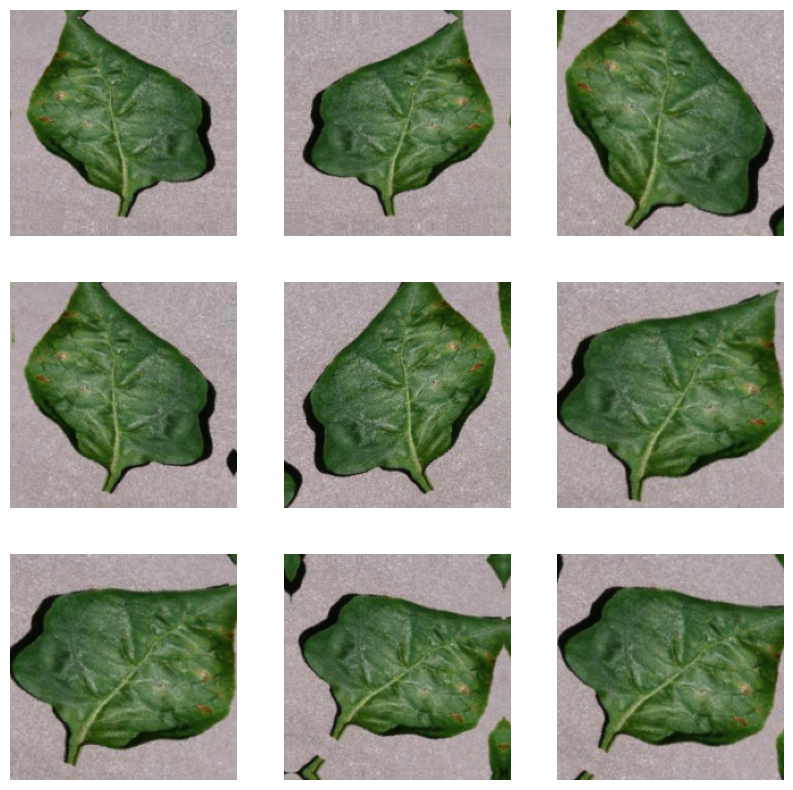

In [21]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Build Model with data augmentation**

In [22]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer for regularization
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [23]:
# Compile the new model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9774 - loss: 0.0640 - val_accuracy: 0.9556 - val_loss: 0.2060
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9649 - loss: 0.1025 - val_accuracy: 0.9178 - val_loss: 0.3207
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9745 - loss: 0.0783 - val_accuracy: 0.9364 - val_loss: 0.2684
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9702 - loss: 0.0852 - val_accuracy: 0.9582 - val_loss: 0.2171
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9737 - loss: 0.0859 - val_accuracy: 0.9289 - val_loss: 0.2835
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9758 - loss: 0.0708 - val_accuracy: 0.9560 - val_loss: 0.2031
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9802 - loss: 0.0552 - val_accuracy: 0.9569 - val_loss: 0.1834
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9774 - loss: 0.0670 - val_acc

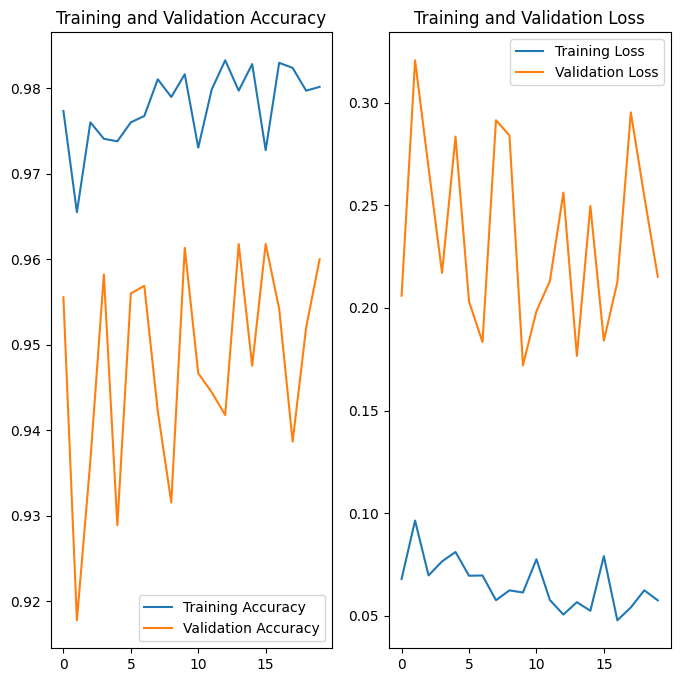

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to Tomato___healthy with a 100.00 percent confidence.


In [27]:
# Train the model with data augmentation and dropout
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Extract and plot the new training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Update the range to match the number of epochs in the second training session
epochs_range = range(epochs)  # This should now correspond to 15 epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Load and preprocess a new image for prediction
img = tf.keras.utils.load_img("e2f520b1-ac21-445b-9a3f-cb6e506e3044___RS_HL 0381.JPG", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Expand dimensions for batch size

# Make predictions and output the result
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


# **TEST**

In [25]:
#TEST
# Load and preprocess a new image for prediction
img = tf.keras.utils.load_img("aca08460-3229-47d9-9ce6-7b2bb9f1ce7f___JR_B.Spot 8901.JPG", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Expand dimensions for batch size

# Make predictions and output the result
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
This image most likely belongs to Pepper,_bell___Bacterial_spot with a 100.00 percent confidence.


In [26]:
#TEST
# Load and preprocess a new image for prediction
img = tf.keras.utils.load_img("de357e36-5be1-4e18-a590-77436b295089___JR_HL 8430.JPG", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Expand dimensions for batch size

# Make predictions and output the result
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to Pepper,_bell___healthy with a 99.07 percent confidence.
